In [26]:
import pandas as pd

# Problem I: predicting whether to contact a customer because they are at risk of churning

*Churn* is the therm used when a company loses a customer.
In this problem, you'll build a Machine Learning model that identifies customers that are at risk of churning.
This problem is based on Chapter 3 of [*Machine Learning for Business*](https://www.manning.com/books/machine-learning-for-business).

<img src="ML for business.png" alt="Drawing" style="width: 150px;"/>

## Introduction

You are the Head of Operations for a commercial company that sells high-quality products.
Most of your customer have used your company for a long time, but you still regularly lose customers to your competitors.
To help retain customers, you want to identify those customers who are at risk of churning so you can call them to determine whether there is some way to address their move to another supplier.

<img src="im2.png" alt="Drawing" style="width: 500px;"/>

In [27]:
# load the data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/churn_data.csv'
data = pd.read_csv(url, index_col = 'id')
data.head()

,churned,customer_code,co_name,total_spend,week_minus_4,week_minus_3,week_minus_2,last_week,4-3_delta,3-2_delta,2-1_delta
id,,,,,,,,,,,
1,0,1826,Hoffman Martinez and Chandler,68567.34,0.81,0.02,0.74,1.45,-0.79,0.72,0.71
2,0,772,Lee Martin and Escobar,74335.27,1.87,1.02,1.29,1.19,-0.85,0.27,-0.10
3,0,479,Hobbs Mcdaniel and Baker,48746.22,1.21,0.70,1.04,2.12,-0.51,0.34,1.08
4,0,1692,Williams-Harris,64416.70,0.75,2.08,2.40,2.02,1.33,0.32,-0.38
5,0,2578,Beck-Snyder,71623.20,2.33,0.66,1.97,1.60,-1.67,1.31,-0.37


**Data Description**


| Feature | Description |
| :- | -: |
| churned | whether the custumer churned (1) or not (0) |
| customer_code | unique customer identification code |
| co_name | company name |
| total_spend | the sum of the total spent over the year | 
| week_minus_4 <br> week_minus_3 <br> week_minus_2 <br> last_week | weekly spend as a percentage of the average spend |
| 4-3_delta <br> 3-2_delta <br> 2-1_delta | weekly change relative to the average spend |

For example, in week_minus_3, Hoffman Martinez and Chandler 

In [28]:
data.head(1)

,churned,customer_code,co_name,total_spend,week_minus_4,week_minus_3,week_minus_2,last_week,4-3_delta,3-2_delta,2-1_delta
id,,,,,,,,,,,
1,0,1826,Hoffman Martinez and Chandler,68567.34,0.81,0.02,0.74,1.45,-0.79,0.72,0.71


has sales that are 0.02 times their average week.
In week_minus_4, their sales are 0.81 times their average sales. 
This means that their weekly sales decrease by 0.79 of their normal sales from week_minus_4 to week_minus_3.
This is shown by a -0.79 in the the 4-3_delta column.

The are 2999 customers

In [29]:
len(data)

2999

We have an imbalanced dataset (most customers did not churn)

In [30]:
# number of customers that churned
data.churned.value_counts()

0    2833
1     166
Name: churned, dtype: int64

The **goal** is to build a classification pipeline that predicts whether a customer will churn or not based on the columns `total_spend`, `week_minus_4`, `week_minus_3`, `week_minus_2`, `last_week`, `4-3_delta`, `3-2_delta`, and `2-1_delta`

**Part 1:** Define X and y from the DataFrame, and then split X and y into training and testing sets.

In [31]:
# Feature matrix X, target vector y
X = data.drop(columns=['churned', 'co_name', 'customer_code'],axis=1)
y = data.churned

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42, stratify=y)

In [32]:
y_train.value_counts()

0    2125
1     124
Name: churned, dtype: int64

**Part 2:**  build a  random forest classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model (using the default parameters)
forest = RandomForestClassifier(class_weight='balanced')

**Part 3:** use a grid search to tune the random forest hyperparameters (Use **recall** as the model evaluation metric)

**Remark:** Many scikit-learn [classification models](https://www.google.com/search?q=random+forest+classifier+sklearn&rlz=1C1CHBF_enUS767US767&oq=random+forest+class&aqs=chrome.2.0i433i512j69i57j0i512l4j69i60l2.5119j0j9&sourceid=chrome&ie=UTF-8) have a `class_weight` hyperparameter.
Setting `class_weight= 'balanced'` places more emphasis on the minority class.

In [34]:
from sklearn.model_selection import GridSearchCV

# define the parameter values that should be searched
n_estimators_range = [100, 200]
max_depth_range = [1, 2, 10]
min_samples_split_range = [2, 5]
min_samples_leaf_range = [1, 2]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators_range,max_depth=max_depth_range,
                  min_samples_split=min_samples_split_range,
                  min_samples_leaf=min_samples_leaf_range)

In [35]:
# instantiate and fit the grid
grid = GridSearchCV(forest, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


**Part 4:** evaluate the performance of your classification pipeline on the test set

In [39]:
y_test_pred = best_model.predict(X_test)

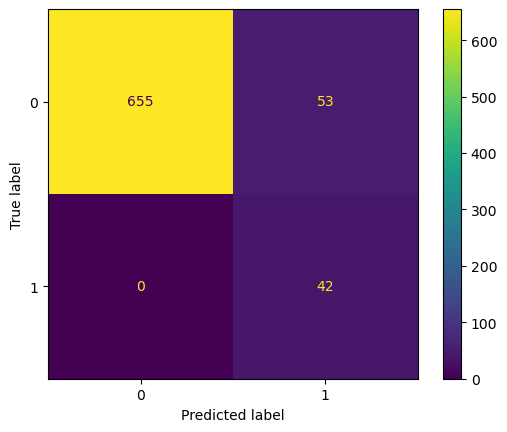

In [40]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()


In [41]:
# accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)


0.9293333333333333

In [42]:
# recall
from sklearn.metrics import recall_score
recall_score(y_test, y_test_pred)


1.0

**Part 5:** Use the `feature_importances_` method to plot the estimated importance of each feature ([read this first](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)).

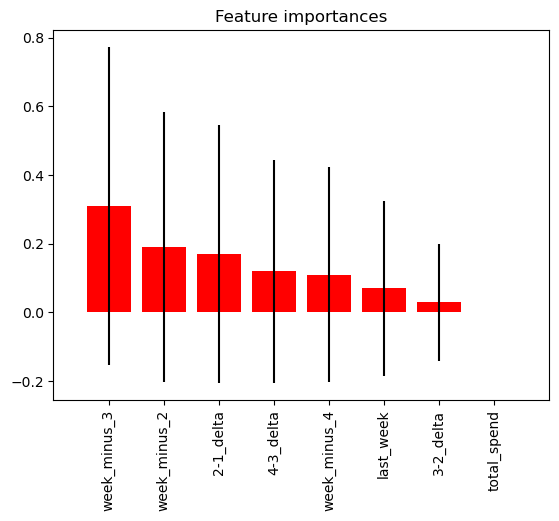

In [43]:
# plot feature importances
import matplotlib.pyplot as plt
import numpy as np
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()